In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

File này nằm trong bài nộp cùng với file .csv có dữ liệu về commit data của Repo được sử dụng.

Thầy hãy tải cả file .csv được đính kèm về để chạy các đoạn code sau, hoặc chạy block ở dưới sẽ phải đợi ~20p để có file tự tạo. 


Code block dưới đây dùng để lấy dữ liệu từ repo về lưu thành file .csv, để tránh mỗi lần phân tích lại phải load data mất ~20 phút.


In [59]:
from github import Github
import csv

g = Github("")
#ORIGINAL ACCOUNT TOKEN
repo_owner = 'pytorch'
repo_name = 'rl'

repo = g.get_repo(f"{repo_owner}/{repo_name}")

csv_file = 'pytorch_data_written_file.csv'

with open(csv_file, mode='w', newline='', encoding='utf-8-sig') as file:
    writer = csv.writer(file)
    writer.writerow(['Commit ID', 'Commit Message', 'Author Name', 'Author Email', 'Date of Commit', 'Files Changed', 'Passed all checks'])
    commits = repo.get_commits()
    for commit in commits:
        commitID = commit.sha #commitID
        commitMessage = commit.commit.message #commitMessage
        authorName = commit.commit.author.name #authorName
        authorEmail = commit.commit.author.email #authorEmail
        commitDate = commit.commit.author.date.strftime("%Y-%m-%d %H:%M:%S") #commitDate
        files = commit.files 
        changedFiles = [file.filename for file in files] #changedFiles
        checks = commit.get_check_runs()
        passed = all(check.conclusion == 'success' for check in checks) #passed

        writer.writerow([commitID, commitMessage, authorName, authorEmail, commitDate, changedFiles, passed])



# Mở và xem trước file

In [68]:
df = pd.read_csv('pytorch_data_written_file.csv')

In [69]:
df.head()

,Commit ID,Commit Message,Author Name,Author Email,Date of Commit,Files Changed,Passed all checks
0,11de8e5feb54f6b5dce5dc2f045fc8143192f06a,[BugFix] Fix SAC (#1190),Vincent Moens,vincentmoens@gmail.com,2023-05-23 19:59:56,['torchrl/objectives/sac.py'],False
1,ff900774ca0b1179429bb37cd7d99d482dfeb851,[Performance] Improve performance and streamli...,Martin Marenz,marenz@meta.com,2023-05-23 19:24:57,['torchrl/objectives/value/functional.py'],False
2,12ad69e9069036593147e613fc254d97fde89421,[Refactor] Better updaters (#1184),Vincent Moens,vincentmoens@gmail.com,2023-05-23 14:55:19,"['examples/discrete_sac/discrete_sac.py', 'exa...",False
3,b4cf4d7472268d5caee7151900d2aff194474219,[Nova] Removing CircleCI Gym Unittests (#1179),Omkar Salpekar,osalpekar@fb.com,2023-05-23 12:33:26,['.circleci/config.yml'],False
4,ae10bb892b3d3139be364216b9dcc5dc9bdea497,[BugFix] Fix SAC (#1189),Vincent Moens,vincentmoens@gmail.com,2023-05-23 12:31:15,"['examples/sac/sac.py', 'torchrl/objectives/sa...",False


In [70]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Commit ID          790 non-null    object
 1   Commit Message     790 non-null    object
 2   Author Name        790 non-null    object
 3   Author Email       790 non-null    object
 4   Date of Commit     790 non-null    object
 5   Files Changed      790 non-null    object
 6   Passed all checks  790 non-null    bool  
dtypes: bool(1), object(6)
memory usage: 37.9+ KB


,Commit ID,Commit Message,Author Name,Author Email,Date of Commit,Files Changed,Passed all checks
count,790,790,790,790,790,790,790
unique,790,784,116,118,790,550,2
top,11de8e5feb54f6b5dce5dc2f045fc8143192f06a,Update README.md,Vincent Moens,vincentmoens@gmail.com,2023-05-23 19:59:56,['README.md'],True
freq,1,5,505,518,1,30,533


# Data Cleaning & Processing

## Dựa trên df.info(), dataFrame trên không có giá trị NULL => không cần lọc các hàng NaN

### Loại bỏ các hàng có thể trùng do lỗi khi lấy data. Các hàng trùng nhau sẽ có ID giống nhau

In [71]:
df.drop_duplicates(subset=['Commit ID'], inplace= True)

### Process bằng cách extract ra các cột Ngày, Tháng, Năm từ cột thời gian commit

In [72]:
df['Date of Commit'] = pd.to_datetime(df['Date of Commit'])
df['Commit Year'] = df['Date of Commit'].dt.year
df['Commit Month'] = df['Date of Commit'].dt.month
df['Commit Day'] = df['Date of Commit'].dt.day
df.head()

,Commit ID,Commit Message,Author Name,Author Email,Date of Commit,Files Changed,Passed all checks,Commit Year,Commit Month,Commit Day
0,11de8e5feb54f6b5dce5dc2f045fc8143192f06a,[BugFix] Fix SAC (#1190),Vincent Moens,vincentmoens@gmail.com,2023-05-23 19:59:56,['torchrl/objectives/sac.py'],False,2023,5,23
1,ff900774ca0b1179429bb37cd7d99d482dfeb851,[Performance] Improve performance and streamli...,Martin Marenz,marenz@meta.com,2023-05-23 19:24:57,['torchrl/objectives/value/functional.py'],False,2023,5,23
2,12ad69e9069036593147e613fc254d97fde89421,[Refactor] Better updaters (#1184),Vincent Moens,vincentmoens@gmail.com,2023-05-23 14:55:19,"['examples/discrete_sac/discrete_sac.py', 'exa...",False,2023,5,23
3,b4cf4d7472268d5caee7151900d2aff194474219,[Nova] Removing CircleCI Gym Unittests (#1179),Omkar Salpekar,osalpekar@fb.com,2023-05-23 12:33:26,['.circleci/config.yml'],False,2023,5,23
4,ae10bb892b3d3139be364216b9dcc5dc9bdea497,[BugFix] Fix SAC (#1189),Vincent Moens,vincentmoens@gmail.com,2023-05-23 12:31:15,"['examples/sac/sac.py', 'torchrl/objectives/sa...",False,2023,5,23


## Loại bỏ các cột sẽ không dùng đến trong bài để dữ liệu được cô đọng

In [73]:
df.drop(['Author Email','Date of Commit'], axis=1, inplace=True)

## Chuyển dữ liệu về đúng kiểu

In [74]:
df['Commit ID'] = df['Commit ID'].astype(str)
df['Files Changed'] = df['Files Changed'].astype(str)
df['Commit Message'] = df['Commit Message'].astype(str)
df['Author Name'] = df['Author Name'].astype(str)
df['Passed all checks'] = df['Passed all checks'].astype(bool)

In [75]:
df.dtypes

Commit ID            object
Commit Message       object
Author Name          object
Files Changed        object
Passed all checks      bool
Commit Year           int64
Commit Month          int64
Commit Day            int64
dtype: object

## Loại giá trị vô lý (nếu có)

In [76]:
df = df[df['Commit Year'] < 2024]
df = df[(df['Commit Month'] <= 12) & (df['Commit Month'] >= 1)]
df = df[(df['Commit Day'] <= 31) & (df['Commit Month'] >= 1)]

In [77]:
df

,Commit ID,Commit Message,Author Name,Files Changed,Passed all checks,Commit Year,Commit Month,Commit Day
0,11de8e5feb54f6b5dce5dc2f045fc8143192f06a,[BugFix] Fix SAC (#1190),Vincent Moens,['torchrl/objectives/sac.py'],False,2023,5,23
1,ff900774ca0b1179429bb37cd7d99d482dfeb851,[Performance] Improve performance and streamli...,Martin Marenz,['torchrl/objectives/value/functional.py'],False,2023,5,23
2,12ad69e9069036593147e613fc254d97fde89421,[Refactor] Better updaters (#1184),Vincent Moens,"['examples/discrete_sac/discrete_sac.py', 'exa...",False,2023,5,23
3,b4cf4d7472268d5caee7151900d2aff194474219,[Nova] Removing CircleCI Gym Unittests (#1179),Omkar Salpekar,['.circleci/config.yml'],False,2023,5,23
4,ae10bb892b3d3139be364216b9dcc5dc9bdea497,[BugFix] Fix SAC (#1189),Vincent Moens,"['examples/sac/sac.py', 'torchrl/objectives/sa...",False,2023,5,23
...,...,...,...,...,...,...,...,...
785,17d85d4128fcdfdef657b90967d25fe30cf7c64d,Troubleshooting in README.md,Vincent Moens,['README.md'],True,2022,4,13
786,4f4c827b6564de0511c95c71c1a47dd922d08c66,Fixes minor typos in README.md (#57),Tristan Naumann,['README.md'],True,2022,4,6
787,56907ad37f195fec0ac168d9132a5f70457db737,Disclaimer in readme,Vincent Moens,['README.md'],True,2022,4,1
788,0f70e4f44131d72dd0a107824ad8fdc80fcafa40,CircleCI badge (#55),Vincent Moens,['README.md'],True,2022,4,1


## Lưu vào file mới

In [78]:
df.to_csv('pytrochRl_written_cleaned_file.csv', index=False)

# Data Analysis

Trong phần Analysis, để dễ hình dung 1 số nội dung trả lời cho các câu hỏi được đặt ra, 1 phần của Data Visualization cũng sẽ được đính kèm.

Mọi hình ảnh được đính kèm ở đây cũng sẽ xuất hiện ở mục Data Visualization.

In [79]:
df = pd.read_csv('pytrochRl_written_cleaned_file.csv')

## Ai là những người Commit nhiều nhất?

### Method: Sử dụng cột "Author Name" để đếm số hàng có chứa tên của mỗi người, tổng hợp lại vào 1 DataFrame mới.

In [80]:
#Most active contributor
active_contributor = df['Author Name'].value_counts()
active_contributor = pd.DataFrame(active_contributor).reset_index()
active_contributor.columns = ['Author Name', 'Number of Commits']
active_contributor

,Author Name,Number of Commits
0,Vincent Moens,505
1,nicolas-dufour,28
2,Matteo Bettini,24
3,Tom Begley,16
4,vmoens,13
...,...,...
111,Leroy Pascal,1
112,Sebastian Hätälä,1
113,Julia Gonik,1
114,Serhat Varolgünes,1


Text(0.5, 1.0, 'Commit number per person distribution')

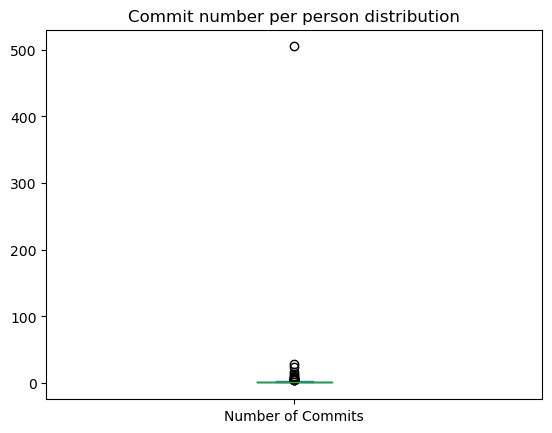

In [81]:
ax = active_contributor.plot(kind='box')
ax.set_title('Commit number per person distribution')

### Trả lời: Vincent Moens là người có hoạt động commit thường xuyên nhất trong repository trên.


## Tần suất Commit của Repository trên?

### Method: Nhóm data lại theo thông tin về Năm và Tháng, rồi đếm số lượng commit trong mỗi mốc thời gian, đưa vào 1 DataFrame mới

In [82]:
#Frequency of commits
#find the value_count of years, month
commit_frequency = df[['Commit Year', 'Commit Month', 'Commit ID']]
commit_frequency = commit_frequency.groupby(['Commit Year', 'Commit Month']).count().reset_index()
commit_frequency = commit_frequency.sort_values(by= 'Commit Year', ascending= False)
commit_frequency.columns = ['Commit Year', 'Commit Month', 'Number of Commits']
print(commit_frequency.sort_values(by='Number of Commits',ascending= False))


    Commit Year  Commit Month  Number of Commits
6          2022             9                 92
10         2023             1                 73
13         2023             4                 71
7          2022            10                 70
2          2022             5                 67
4          2022             7                 62
8          2022            11                 60
3          2022             6                 54
12         2023             3                 49
14         2023             5                 48
1          2022             4                 40
9          2022            12                 38
11         2023             2                 34
5          2022             8                 31
0          2022             3                  1


Text(0.5, 0.98, 'Commit Frequency')

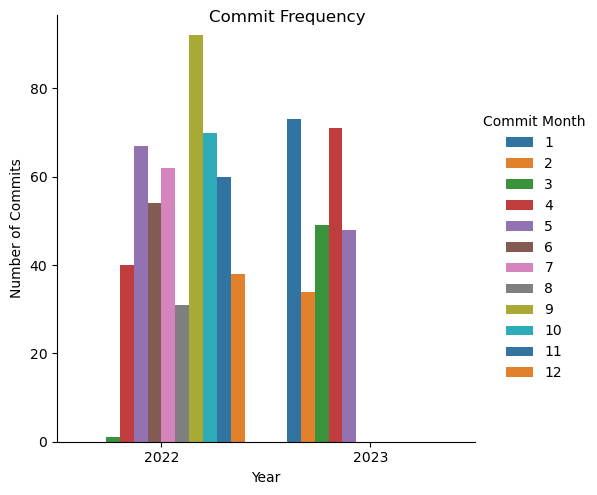

In [83]:
ax = sns.catplot(data= commit_frequency, x= 'Commit Year', y= 'Number of Commits', hue= 'Commit Month', kind= 'bar', palette='tab10')
ax.set_axis_labels('Year', 'Number of Commits')
ax.fig.suptitle('Commit Frequency')

### Trả lời: Repo trên bắt đầu hoạt động từ 3/2022, hoạt động commit thường xuyên nhất vào các tháng 5, 9, 10 của 2022 và tháng 1, 4 của 2023.

## Nội dung chủ yếu của các Commit Message?

### Method: Bằng cách quan sát data từ df.head(), ta thấy nội dung commit hầu hết đều tóm gọn trong 1 chữ trong dấu "[ ]" ở đầu Commit Message.

### Từ đó, ta quan sát data và rút ra 1 loạt các từ phổ biến.

### Sau đó tìm số hàng có chứa mỗi từ phổ biến đó.

In [84]:
#Most commom words in Message
common_words = ['BugFix', 'Performance', 'Refactor', 'Feature', 'Doc', 'CI', 'Update', 'Merge', 'Versioning', 'Minor', 'Test']

In [85]:
contains_words = {}
for word in common_words:
        contains_words[word] = df[df['Commit Message'].str.contains(word, case=False)]['Commit Message']
word_contain_number = pd.DataFrame(contains_words)
word_plot = pd.DataFrame(word_contain_number.count().reset_index())
word_plot.columns = ['Word', 'Number of Messages']
print(word_plot)



           Word  Number of Messages
0        BugFix                 217
1   Performance                   8
2      Refactor                  83
3       Feature                 167
4           Doc                 119
5            CI                  71
6        Update                  60
7         Merge                   7
8    Versioning                  10
9         Minor                  44
10         Test                  93


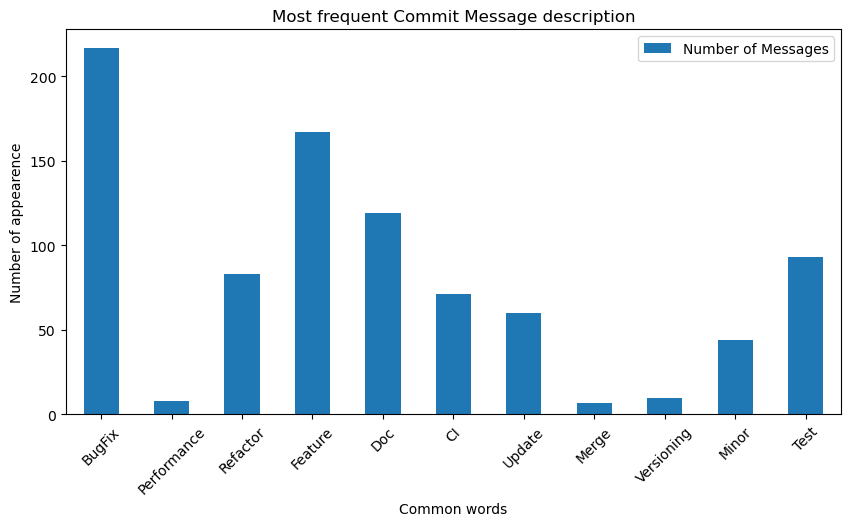

In [86]:
ax = word_plot.plot(x='Word', y='Number of Messages', figsize=(10, 5), kind='bar')
ax.set_xlabel("Common words")
ax.set_ylabel("Number of appearence")
ax.set_title("Most frequent Commit Message description")
plt.xticks(rotation = 45)
plt.show()

### Trả lời: Các từ như BugFix, Feature, Doc, ... là các từ thường xuyên xuất hiện, và là nội dung chủ yếu của các Commit Message

## Các file được chỉnh sửa thường xuyên nhất?

Mỗi khi commit khi có file được sửa, file sẽ được đưa vào muc Files Changed.

Vậy ta tìm số lần xuất hiện của các file có trong mục Files Changed.

### Method: Đoạn ở dưới rất kỳ công, nhưng có thể hiểu như sau:

Nội dung của Files Changed là các đường dẫn cách nhau bằng dấu "," với tên file được chỉnh nằm ở cuối đường dẫn.

Mỗi đường dẫn file lại gồm các file, folder cách nhau bởi dấu "/", tên file nằm sau cùng.

Ta sẽ tách (split) dần dần để lấy được tên file, và tìm số lần nó xuất hiện.

In [87]:
from collections import defaultdict

file_set = []
file_dict = defaultdict(lambda: 1)
for file_data in df['Files Changed']:
    #đầu tiên cần loại bỏ các ký tự râu ria thừa đi
    #sau đó tách các phần tử đường dẫn bằng dấu ","
    stringg = file_data.strip('[]').replace("'", "").split(',')

    for big_file in stringg:
        #từ mỗi đường dẫn, chỉ lấy tên file ở cuối, tách với các địa chỉ đường dẫn khác bằng ký tự "/"
        strip_file = big_file.split("/")

        #thêm các file vào list các File
        if(len(strip_file[len(strip_file) - 1]) > 0):
            file_set.append(strip_file[len(strip_file) - 1])

#Ép kiểu để lấy ra các file unique tạo thành Set
file_set = list(set(file_set))
#Tìm số lần xuất hiện của các file
for file in file_set:
    file_dict[file] = df[df['Files Changed'].str.contains(file.strip(), case=False)].shape[0]

#Tạo dataFrame
file_dict_frame = pd.DataFrame(file_dict, index= range(1)).transpose().reset_index()
file_dict_frame.columns = ['File Name', 'Changed Times']
file_dict_frame.sort_values(by='Changed Times', ascending=False)


,File Name,Changed Times
84,transforms.py,153
6,common.py,137
153,utils.py,130
196,collectors.py,111
125,__init__.py,94
...,...,...
24,halfcheetah_chart.png,1
219,docutils.conf,1
217,modernizr.min.js,1
134,VERSIONING_ISSUES.md,1


### Lưu ý: Một số tên file trong đây cũng xuất hiện trong cột Message, nên nếu thầy dùng Ctrl+F để kiểm tra trên file .csv thì kết quả có thể chệch đi một chút.

### Do số lượng file rất nhiều, ta chỉ minh họa các file có số lần xuất hiện đáng kể (>= 50 lần)

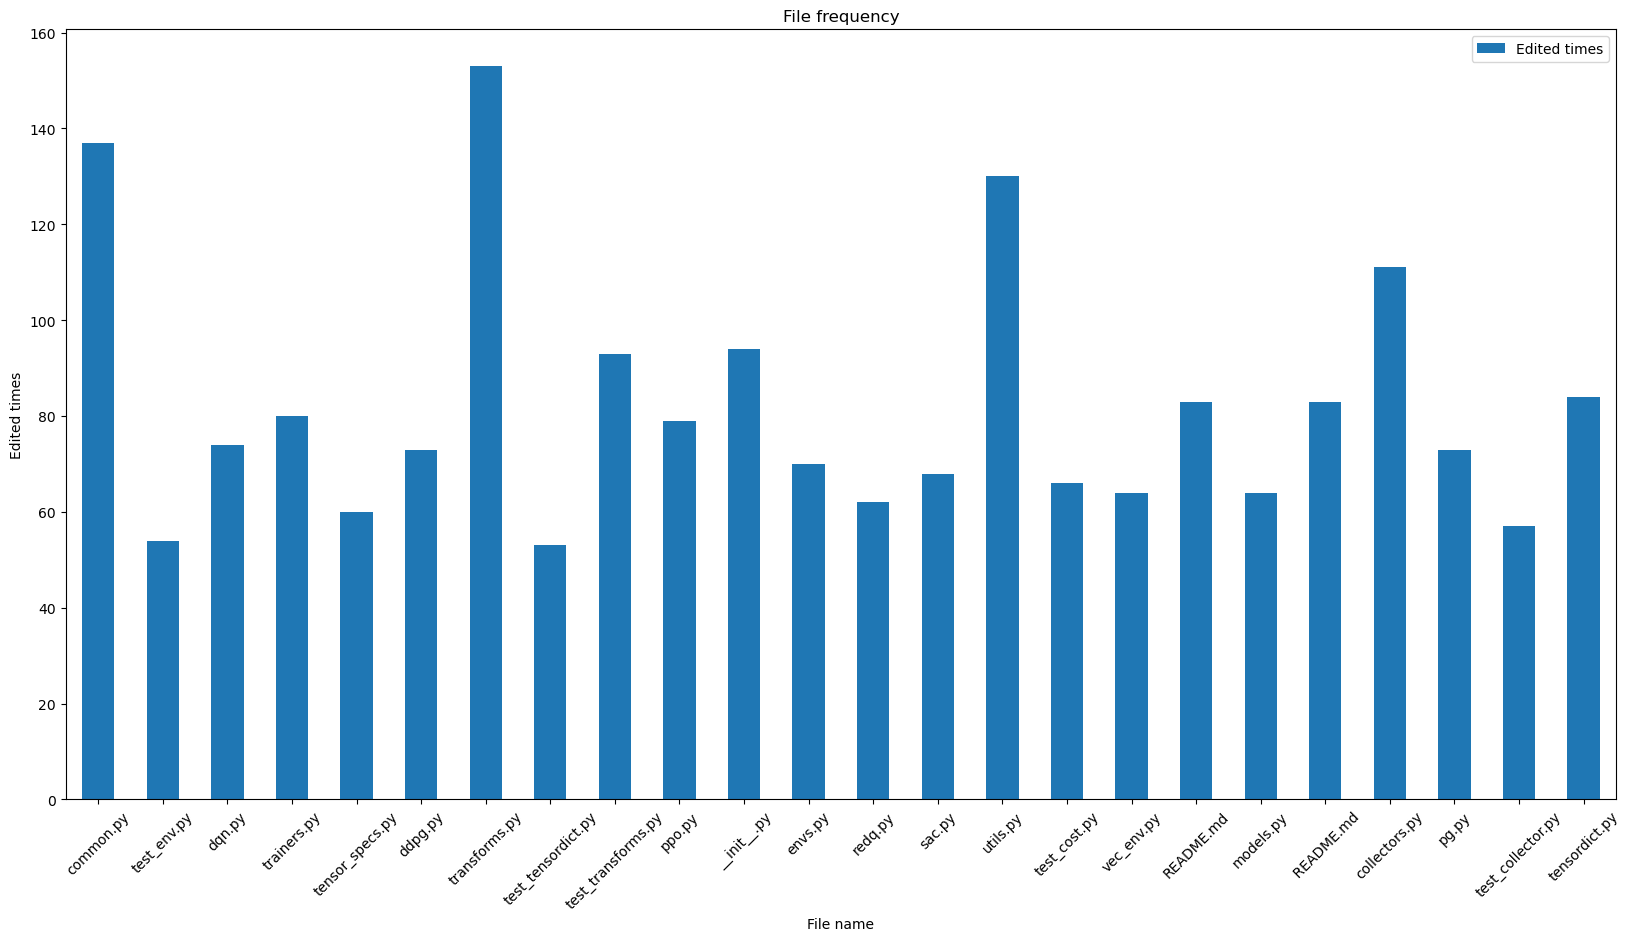

In [88]:
file_plot = pd.DataFrame(file_dict, index= range(1)).transpose().reset_index()
file_plot.columns = ['File Name', 'Edited times']
# file_plot = file_plot.sort_values(by= 'Edited times', ascending=False)
file_plot = file_plot[file_plot['Edited times'] >= 50]
ax = file_plot.plot(x= 'File Name', y= 'Edited times', kind= 'bar', figsize=(20, 10))
plt.xticks(rotation=45)
ax.set_xlabel("File name")
ax.set_ylabel("Edited times")
ax.set_title("File frequency")
plt.show()

### Trả lời: 1 vài file được chỉnh sửa nhiều là "transforms.py", "common.py", ...

## Trong tất cả, có bao nhiêu commit Pass được các test case của repo trên?

### Method: Lấy số hàng có Pass = True chia cho tổng số hàng

In [89]:
pass_percentage = df[df['Passed all checks'] == True].shape[0] / df['Passed all checks'].shape[0] * 100
pass_percentage

67.46835443037975

### Trả lời: 67.46835443037975%

## Đánh giá chất lượng của các Commit của mỗi người (bằng cách xem % commit pass các test trên tổng số commit của mỗi người)?

## Ví dụ: Nam commit 10 lần, pass 8 lần thì 80% số lần commit của Nam vượt qua các test cho sẵn

### Method: Giống với câu hỏi "Trong tất cả, có bao nhiêu commit Pass được các test case của repo trên?" Nhưng cho tên của mỗi người.

In [90]:
passing_rate = {}
unique_names = df['Author Name'].unique()
for name in unique_names:
    passing_rate[name] = round(df[(df['Author Name'] == name) & (df['Passed all checks'] == True)].shape[0] / df[df['Author Name'] == name].shape[0] * 100, 1)
passing_rate_frame = pd.DataFrame(passing_rate, index= range(1)).transpose()
passing_rate_frame = passing_rate_frame.reset_index()
passing_rate_frame.columns = ['Name', 'Passing Percentage']
passing_rate_frame.sort_values(by='Passing Percentage', ascending=False)


,Name,Passing Percentage
58,jrobine,100.0
87,jiazhou wang,100.0
85,Matt White,100.0
84,Fridolin Linder,100.0
83,Filip Dabek,100.0
...,...,...
23,Xuehai Pan,0.0
26,Nikita Shulga,0.0
51,Sebastian Hätälä,0.0
38,Adnan Akhundov,0.0


### Trả lời: Thông tin về tỉ lệ đúng khi Commit của mỗi người đều có thể được xác định trong bảng passing_rate_frame

## Tìm độ khó xử lý của các file (tỉ lệ Fail test khi chỉnh sửa và commit file ấy)?

In [91]:
file_set
file_fails = {}

In [92]:
for file in file_set:
    file_fails[file] = df[(df['Files Changed'].str.contains(file.strip(), case=False)) & (df['Passed all checks'] == False)].shape[0] / df[df['Files Changed'].str.contains(file.strip(), case=False)].shape[0] * 100

file_fails
file_fails_frame = pd.DataFrame(file_fails, index= range(1)).transpose().reset_index()
file_fails_frame.columns = ['File Name', 'Failure rate']
file_fails_frame.head(10)


,File Name,Failure rate
0,trainers.rst,75.000000
1,dreamer_utils.py,40.000000
2,segment_tree.h,0.000000
3,cheetah_smoketest.txt,0.000000
4,ray.py,100.000000
5,pytorch-logo-flame.png,66.666667
6,common.py,31.386861
7,transformer.png,0.000000
8,test_specs.py,100.000000
9,csv.py,50.000000


### Trả lời: Tỉ lệ Fail khi Commit của từng file đều có thể được xác định trong bảng file_fails_frame

## Những file nào được sửa theo những mục đích nào nhiều nhất?

### Method: Nhờ các câu hỏi phía trước, ta thu thập được thông tin về tên các file, cũng như các nội dung phổ biến trong Commit.
### Nên chỉ cần kiểm tra từng hàng xem có nội dung commit nào tương ứng với các file nào.

Ví dụ: Các Commit với mục đích "BugFix" hướng nhiều nhất đến các file như "transform.py", "collector.py", ...

### Đoạn dưới đây sẽ chạy mất chút thời gian, không phải do lỗi

In [93]:
magnum_opus = pd.DataFrame(index= file_set, columns= common_words)
for index in range(0, len(df)):
    for word in common_words:
        if word in df.iloc[index]['Commit Message']:
            for file in file_set:
                if file in df.iloc[index]['Files Changed']:
                    if pd.isna(magnum_opus.loc[file, word]):
                        magnum_opus.loc[file, word] = 1
                    else: 
                        magnum_opus.loc[file, word] += 1
for word in common_words:
     for file in file_set:
         if pd.isna(magnum_opus.loc[file, word]):
             magnum_opus.loc[file, word] = 0


In [94]:
magnum_opus

,BugFix,Performance,Refactor,Feature,Doc,CI,Update,Merge,Versioning,Minor,Test
trainers.rst,0,0,3,4,10,0,0,0,0,1,1
dreamer_utils.py,5,0,6,6,0,1,1,0,0,1,1
segment_tree.h,0,0,0,0,0,0,0,2,0,0,0
cheetah_smoketest.txt,1,0,1,1,0,0,0,0,0,0,0
ray.py,0,0,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
modules.rst,0,0,5,5,11,2,1,0,0,0,0
a2c_mujoco_halfcheetah.png,0,0,0,0,0,0,0,0,0,0,0
tensordict.py,17,0,8,24,1,1,3,2,0,0,3
run-clang-format.py,1,0,0,8,0,2,0,0,0,0,1


## Sau khi có dataFrame cần thiết, muốn biết file nào được chỉnh với nội dung nào nhiều nhất, chỉ cần điền nội dung đó vào ô by=' ' 

In [95]:
magnum_opus.sort_values(by='BugFix', ascending=False)

,BugFix,Performance,Refactor,Feature,Doc,CI,Update,Merge,Versioning,Minor,Test
transforms.py,47,0,27,47,6,4,3,0,0,3,4
collectors.py,33,0,19,25,6,7,5,0,0,5,0
common.py,31,0,26,41,8,4,6,1,0,5,3
utils.py,24,4,30,43,8,7,4,0,0,2,2
test_transforms.py,22,0,16,39,1,2,3,0,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...
.clang-format,0,0,0,0,0,0,0,0,0,0,0
_extension.py,0,0,0,1,0,0,0,0,0,0,0
rl_template.rst,0,0,0,0,0,0,0,0,0,0,0
pytorch-logo-dark.svg,0,0,0,0,6,0,0,0,0,0,0


Các Commit với mục đích "BugFix" hướng nhiều nhất đến các file như "transform.py", "collector.py", ...

Các Commit với mục đích "Performance" hướng nhiều nhất đến các file như "functional.py", "utils.py", ...

Các Commit với mục đích "Refactor" hướng nhiều nhất đến các file như "utils.py", "transforms.py", ...

. . .

# Data Visualization

## Who are the most active contributors?

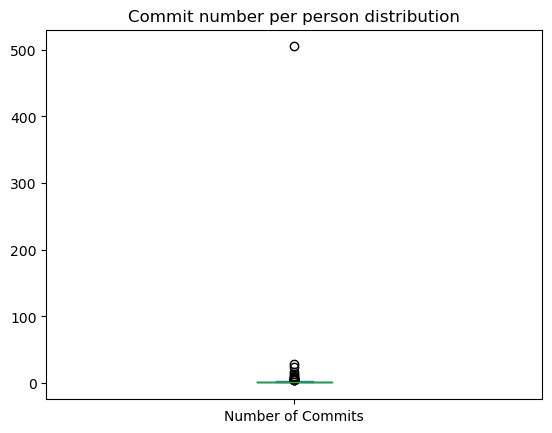

In [96]:
ax = active_contributor.plot(kind='box')

ax.set_title('Commit number per person distribution')
plt.show()

## What is the frequency of commits?

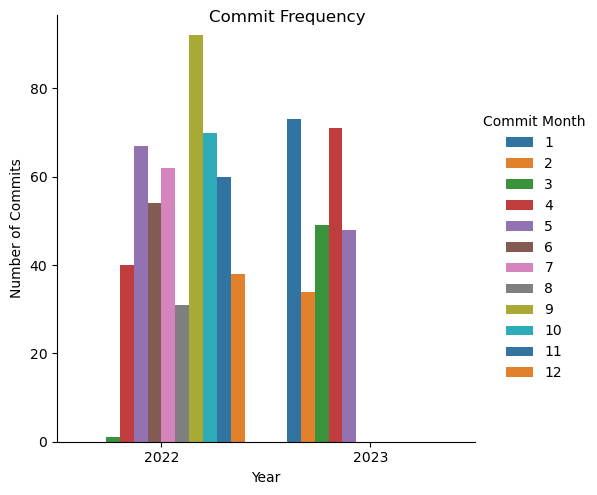

In [97]:
ax = sns.catplot(data= commit_frequency, x= 'Commit Year', y= 'Number of Commits', hue= 'Commit Month', kind= 'bar', palette='tab10')


ax.set_axis_labels('Year', 'Number of Commits')
ax.fig.suptitle('Commit Frequency')
plt.show()

## Nội dung chủ yếu của các Commit Message?

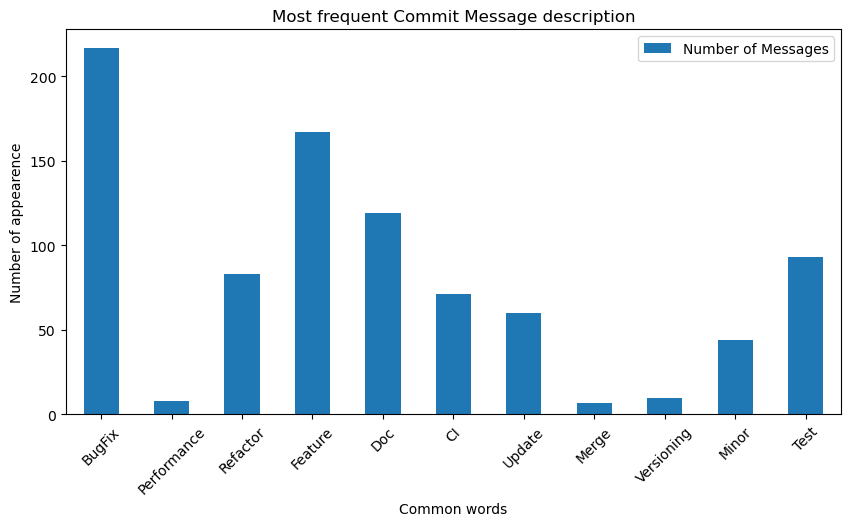

In [98]:
ax = word_plot.plot(x='Word', y='Number of Messages', figsize=(10, 5), kind='bar')


ax.set_xlabel("Common words")
ax.set_ylabel("Number of appearence")
ax.set_title("Most frequent Commit Message description")


plt.xticks(rotation = 45)
plt.show()

## What files are most frequently changed?

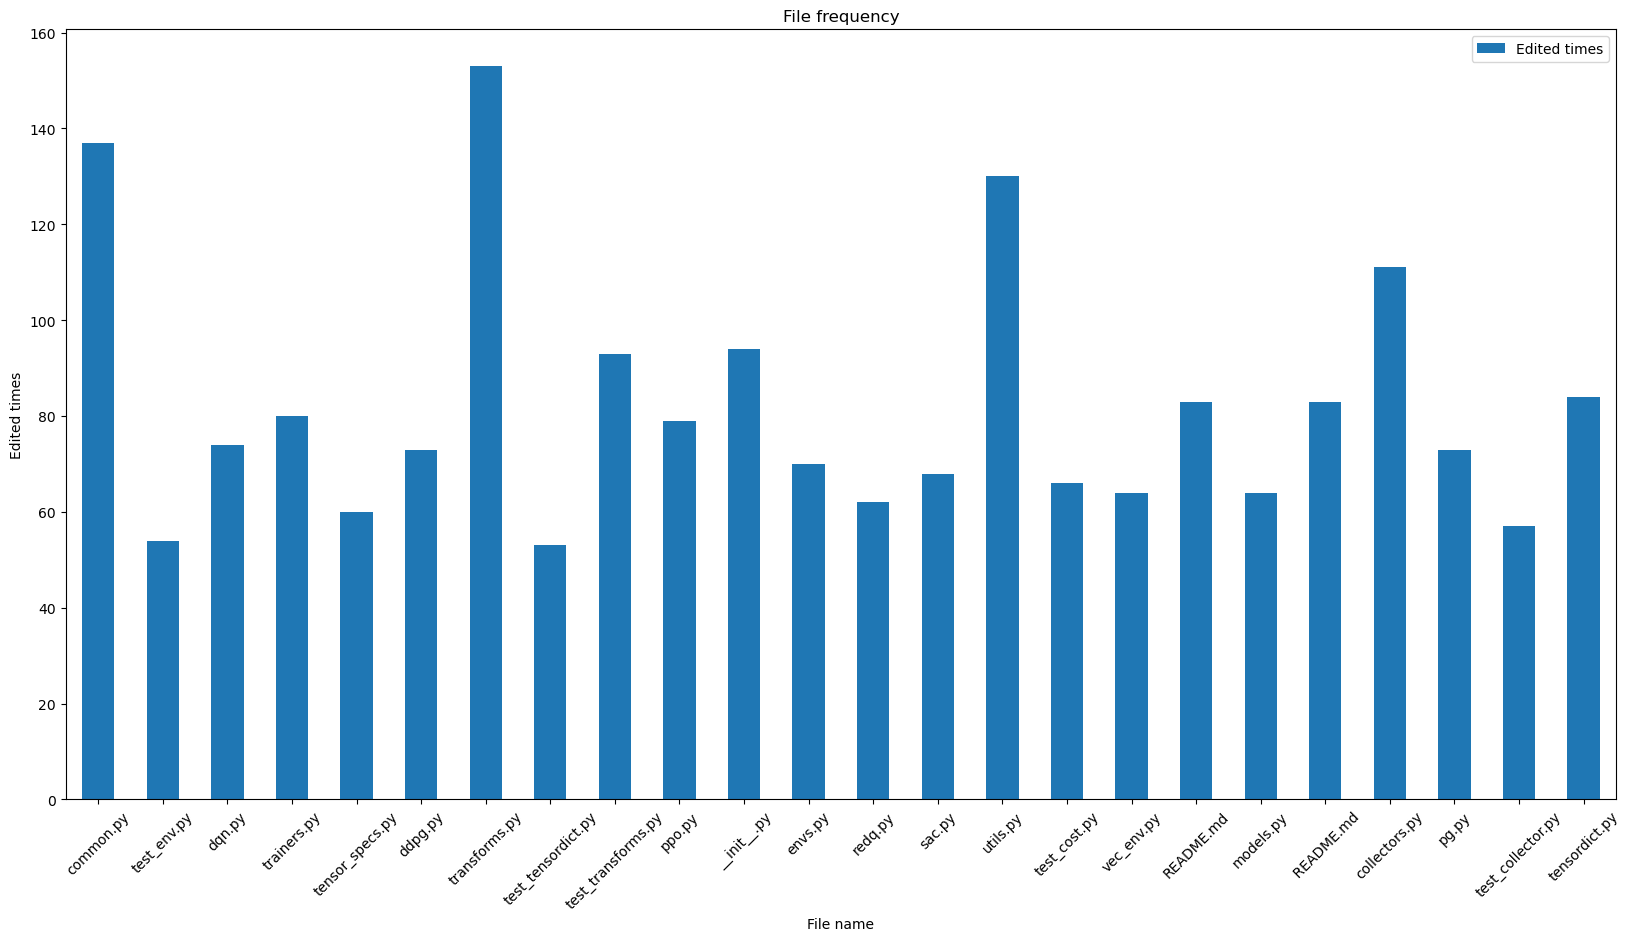

In [99]:
file_plot = pd.DataFrame(file_dict, index= range(1)).transpose().reset_index()
file_plot.columns = ['File Name', 'Edited times']

file_plot = file_plot[file_plot['Edited times'] >= 50]


ax = file_plot.plot(x= 'File Name', y= 'Edited times', kind= 'bar', figsize=(20, 10))

plt.xticks(rotation=45)
ax.set_xlabel("File name")
ax.set_ylabel("Edited times")
ax.set_title("File frequency")
plt.show()

# Interpretation & Conclusion

- Repository trên được phát triển khá độc lập, bởi gần như duy nhất 1 người là Vincent Moens, được cho thấy thông qua độ chênh lệch mạnh ở số lần Commit (dataFrame active_contributor)
- Tìm hiểu sâu hơn, ta tìm được info của người này (https://www.linkedin.com/in/vincent-moens-9bb91972/), ông là 1 TorchRL Developer (repo được sử dụng trong bài có tên là RL và chủ repo là pyTorch)
=> Repo này đã được giao cho Vincent Moens phát triển.

- Repository trên hoạt động khá thường xuyên. Một trong những lý do khả thi cho khẳng định trên là để tạo thêm tiến độ cho việc release TorchRL phiên bản Beta và bản 2.0 của PyTorch (https://twitter.com/torchrl1/status/1636477654927900677?cxt=HHwWioC8jbfw97UtAAAA)

- Việc các từ khóa xuất hiện nhiều nhất trong Commit Message là "BugFix", "Feature" và "Doc" khẳng định thêm rằng TorchRL đang trong giai đoạn phát triển => Việc sửa lỗi nhiều và thêm nhiều các tính năng là thường thấy.

- Kết hợp thông tin từ các bảng file_dict_frame (Số lần được chỉnh sửa của các file),
 file_fails_frame (khả năng fail testcases khi chỉnh sửa các file nhất định),
  và magnum_opus (các file được sửa nhiều nhất theo các mục đích khác nhau):

  Các file được chỉnh sửa nhiều nhất đều có tỉ lệ khiến Fail test dưới 50%

  Các file được chỉnh sửa với mục đích FixBug và Refactor nhiều nhất đều hướng đến các file được chỉnh sửa nhiều nhất

  => Các file như "transforms.py", "collectors.py", "utils.py" là các file được phát triển và sửa chữa với cường độ lớn nhất
